# Clasificador de valencia (Positividad, Negatividad).

Este notebook es un complemento de proyecto integrador.

Aquí se procesa lo referente a la elección de los parámetros del clasficador, la creación y almacenamiento del mismo para su uso posterior.

## Análisis de valencia.
Aquí la valencia indica el grado de positividad o negatividad de un texto dado.

Para realizar este clasificador se usaron los tweets ya clasificados de `semeval2018` en el idioma español (2443 tweets en total). Dichos tweets están asignados a alguna de las etiquetas [-3,-2,-1,0,1,2,3] dependiendo de su valencia, siendo: 
 
|||
|-|-|
|**Etiqueta**|**Descripción**|
|-3|se infiere un estado emocional muy negativo|
|-2|se infiere un estado emocional moderadamente negativo|
|-1|se infiere un estado emocional ligeramente negativo|
|0|se infiere un estado emocional neutral or mixto|
|1|se infiere un estado emocional ligeramente positivo|
|2|se infiere un estado emocional moderadamente positivo|
|3|se infiere un estado emocional muy positivo|

Usando todas los tweets, con todas sus etiquetas, no se alcanzaron buenos resultados por lo que se decidió solo usar los etiquetados con los casos más extremos `-3 (muy negativo)` y `3 (muy positivo)`.

In [1]:
# Ocultar In[] y Out[] en cada celda.
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

In [1]:
# Multiple outputs per cell in Jupyter 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext jupyternotify
%autonotify -a 30

<IPython.core.display.Javascript object>

In [2]:
%%javascript
// Evitar autoscroll.
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
from integrado import *
from skeleton import *
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Serban\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<IPython.core.display.Javascript object>

##### Función para probar clasificador
Se crea, entrena y se mide el desempeño del clasificador usando las medidas f1-score, recall-macro y acurracy.

In [4]:
from sklearn.metrics import (recall_score, f1_score,
                             precision_score, accuracy_score)
# Función genérica para crear clasificador, entrenar, predecir, medir desempeño y plotear resultados.
def testClassifier(clf,train,y_train,test,y_test,plot=True):
    clf=clf.fit(train,y_train)
    #Predecimos las etiqueta del conjunto de prueba
    yp=clf.predict(test)
    # Medidas de bondad
    scores={}

    scores['f1_macro']=f1_score(y_test,yp,average='macro')
    scores['recall_macro']=recall_score(y_test,yp,average='macro')
    scores['accuracy']=accuracy_score(y_test,yp)
    
    #Vemos la frontera de decisión
    if plot: plotDecisionBoundary(clf,train, y_train)
    
    del(clf)
    del(yp)
    gc.collect()
    return scores

### Modelo Fasttext preentrenado
Se puede encontrar la implementación de esta clase en el archivo `integrado.py`, la cual simplemente crea el modelo Fasttext, lo entrena y lo almacena en un archivo .pickle para su uso posterior o bien solo lo carga de desde el archivo especificado dependiendo de los parámetros de entrada.

El modelo se ha entrenado con los 200,000 tweets del archivo `geo-mx-2004.json`.

Este modelo servirá para encontrar la representación vectorial de los textos de los tweets.

In [5]:
# Cargando modelo preentrenado.
ft=FTModel(None,file="ftmodel.pickle",replace=False)

** Replace is off. C:\Users\Serban\00_MCDI\S4sem\S4RI\B6_ProyectoIntegrador\ftmodel.pickle already exists, then load.
Load...
** Model C:\Users\Serban\00_MCDI\S4sem\S4RI\B6_ProyectoIntegrador\ftmodel.pickle loaded: [OK]. All done !!.


##### Carga, selección y transformación de datos

In [19]:
all_data=pd.read_json('data/semeval2018_valence_Es_all.json',lines=True) # Cargamos los datos.
all_data=all_data.query("klass == -3 or klass == 3") # Seleccionamos las etiquetas extremo.
all_data['klass']=all_data['klass'].map({-3:0,3:1}) # Mapeamos a otro dominio.
# Creamos representación vectorial.
all_data['vec']=all_data.apply(lambda row: ft.computeEmbedding(preprocess(row['text'])), axis=1)
## Examinamos datos resultantes.
print("Longitud del vector Fasttext:",len(all_data.iloc[0].vec))
print("Clases:",all_data.klass.unique())
print("Dimensiones del conjunto de datos:", all_data.shape)
all_data.head()[['klass','klass_desc','text','vec']]

Longitud del vector Fasttext: 100
Clases: [1 0]
Dimensiones del conjunto de datos: (467, 6)


,klass,klass_desc,text,vec
4,1,se infiere un estado emocional muy positivo,A celebrar con gusto,"[0.49437872, 0.3418805, -0.7748704, -0.8600693..."
12,1,se infiere un estado emocional muy positivo,Intento hacer sonreír a la gente,"[-0.97179496, 2.2770703, -0.74351424, -0.80527..."
22,0,se infiere un estado emocional muy negativo,Estoy to’ triste porque el culebrón catalán ac...,"[0.23631933, 0.7596901, 0.1986684, -0.16699386..."
26,0,se infiere un estado emocional muy negativo,"Llega a tener algo grave, la batata esa se la ...","[-0.42306927, 0.768877, -0.04611562, 0.3279031..."
32,1,se infiere un estado emocional muy positivo,Hermoso dia! Hermosa visita. Por arrancar la ...,"[-0.2724616, 1.3803662, 0.5425671, 1.2152714, ..."


## Pruebas y búsqueda de parámetros óptimos.
Antes de crear el clasificador final se usan los conjuntos de entrenamiento y pruebas para validar/inspeccionar el clasificador resultante.

##### Separación de datos en train y test (80-20)

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(all_data, test_size=0.2)
len(train_data),len(train_data)/len(all_data),
len(test_data),len(test_data)/len(all_data)
len(train_data)+len(test_data)

(373, 0.7987152034261242)

(94, 0.2012847965738758)

467

##### Transformación de dataframe a arrays X, y.

In [8]:
train,y_train=np.array([np.array(x) for x in train_data.vec]),np.array(train_data.klass)
test,y_test=np.array([np.array(x) for x in test_data.vec]),np.array(test_data.klass)

##### Inspección para encontrar parámetros ideales.
Se itera sobre todas las combinaciones posibles de función de distancia y tipos de centroides, buscando la que resulta en un mejor desempeño usando f1-macro score.

In [9]:
DISTANCES='coseno','euclidiana'
CTYPES='Average','Sum','Rocchio','NormSum'
P={}
for dist in DISTANCES:
    for typ in CTYPES:
        print(f"== distance={dist}; centroid_type={typ}; ",end=' ')
        P[f"{dist}-{typ}"]=testClassifier(
            NearestCentroid(distance=dist,centroid_type=typ),
            train,y_train,test,y_test,plot=False)
        print(f"f1_macro={P[f'{dist}-{typ}']['f1_macro']}")

# Tabla de los resultados de FastText.
results=pd.DataFrame(P).T.sort_values("f1_macro",ascending =False)
results
best=results.iloc[0].name.split('-')
print(f"Best are: {best}")

== distance=coseno; centroid_type=Average;  distance: coseno
f1_macro=0.747045747045747
== distance=coseno; centroid_type=Sum;  distance: coseno
f1_macro=0.747045747045747
== distance=coseno; centroid_type=Rocchio;  distance: coseno
f1_macro=0.747045747045747
== distance=coseno; centroid_type=NormSum;  distance: coseno
f1_macro=0.747045747045747
== distance=euclidiana; centroid_type=Average;  distance: euclidiana
f1_macro=0.758974358974359
== distance=euclidiana; centroid_type=Sum;  distance: euclidiana
f1_macro=0.29323308270676696
== distance=euclidiana; centroid_type=Rocchio;  distance: euclidiana
f1_macro=0.29323308270676696
== distance=euclidiana; centroid_type=NormSum;  distance: euclidiana
f1_macro=0.747045747045747


,f1_macro,recall_macro,accuracy
euclidiana-Average,0.758974,0.758974,0.765957
coseno-Average,0.747046,0.746154,0.755319
coseno-Sum,0.747046,0.746154,0.755319
coseno-Rocchio,0.747046,0.746154,0.755319
coseno-NormSum,0.747046,0.746154,0.755319
euclidiana-NormSum,0.747046,0.746154,0.755319
euclidiana-Sum,0.293233,0.500000,0.414894
euclidiana-Rocchio,0.293233,0.500000,0.414894


Best are: ['euclidiana', 'Average']


### Validación de parámetros encontrados.

Con los parámetros elegidos se crea y entrena un clasificador.

In [10]:
clf=NearestCentroid(distance=best[0],centroid_type=best[1])
clf.fit(train,y_train)

distance: euclidiana


Se valida con los datos de test:

Input(test) : [1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1]
Prediction  : [0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1]
{'f1_macro': 0.758974358974359, 'recall_macro': 0.7589743589743589, 'accuracy': 0.7659574468085106}


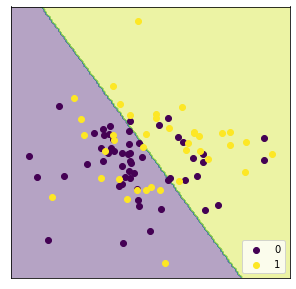

In [11]:
ypred=clf.predict(test)
print("Input(test) :",y_test[:30])
print("Prediction  :",ypred[:30])
scores={}
scores['f1_macro']=f1_score(y_test,ypred,average='macro')
scores['recall_macro']=recall_score(y_test,ypred,average='macro')
scores['accuracy']=accuracy_score(y_test,ypred)
print(scores)
plotDecisionBoundary(clf,test, y_test)

Se valida con los datos de train:

Input(train): [0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0]
Prediction  : [0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0]
{'f1_macro': 0.7974838669645072, 'recall_macro': 0.7922772879294618, 'accuracy': 0.8123324396782842}


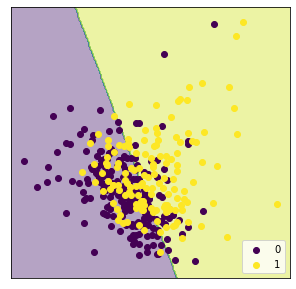

In [12]:
ypred=clf.predict(train)
print("Input(train):",y_train[:30])
print("Prediction  :",ypred[:30])
scores={}
scores['f1_macro']=f1_score(y_train,ypred,average='macro')
scores['recall_macro']=recall_score(y_train,ypred,average='macro')
scores['accuracy']=accuracy_score(y_train,ypred)
print(scores)
plotDecisionBoundary(clf,train, y_train)

Se puede observar que aún con los datos de entrenamiento, que son los que se usaron para crear el clasificador, el máximo f1-score alcanzado es de 0.79. Esto probablemente podría ser mejorado usando una mayor cantidad de tweets, en esta ocasión se usaron 373 para entrenamiento (de un total de 467).

## Creación de clasificador final.
Usando los parámetros óptimos se proceda a crear, entrenar y almacenar el clasificador final. Esta vez se usan el total de los tweets disponibles (467) para el entrenamiento.

In [13]:
X,y=np.array([np.array(x) for x in all_data.vec]),np.array(all_data.klass)

clf=NCClassifier(X,y,
                 distance=best[0],centroid_type=best[1],
                 file="valence-classifier.pickle",replace=True).clf

Create...
distance: euclidiana
Fit...
Save...
** Processed classifier. Saved to C:\Users\Serban\00_MCDI\S4sem\S4RI\B6_ProyectoIntegrador\classifer.pickle.
Load...
** Classifier C:\Users\Serban\00_MCDI\S4sem\S4RI\B6_ProyectoIntegrador\classifer.pickle loaded: [OK]. All done !!.


Se comprueba la correcta carga el clasificador.

In [14]:
clf=NCClassifier(None,None,file="valence-classifier.pickle",replace=False).clf

** Replace is off. C:\Users\Serban\00_MCDI\S4sem\S4RI\B6_ProyectoIntegrador\classifer.pickle already exists, then load.
Load...
** Classifier C:\Users\Serban\00_MCDI\S4sem\S4RI\B6_ProyectoIntegrador\classifer.pickle loaded: [OK]. All done !!.


Algunas pruebas para validar los resultados.

In [15]:
clf.predict([ft.computeEmbedding(preprocess("Muy feliz y contento por esta linda mañana"))])
clf.predict([ft.computeEmbedding(preprocess("Es niña!!!!"))])
clf.predict([ft.computeEmbedding(preprocess("El mundo es horrible, muerte a los miseables"))])
clf.predict([ft.computeEmbedding(preprocess("Nos lleva la que nos trajo"))])

array([1], dtype=int64)

array([1], dtype=int64)

array([0], dtype=int64)

array([0], dtype=int64)